In [ ]:
import os
import pandas as pd
import numpy as np
import glob
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Define paths
base_path = 'ml4h_data/p1'
output_path = 'processed_data'

# Create output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Function to load and preprocess a single patient file
def process_patient_file(file_path, patient_id):
    # Read the patient data file
    df = pd.read_csv(file_path)
    
    # The file is in a different format than expected
    # It has Time, Parameter, Value columns
    
    # First, get static information at time 00:00
    static_data = df[df['Time'] == '00:00']
    
    # Create a dictionary to store static information
    static_info = {}
    for _, row in static_data.iterrows():
        static_info[row['Parameter']] = row['Value']
    
    # Extract patient ID from static information if not provided
    if patient_id is None and 'RecordID' in static_info:
        patient_id = static_info['RecordID']
    
    # Define static variables we want to keep
    static_vars = ['Age', 'Gender', 'Height', 'Weight', 'ICUType', 'RecordID']
    
    # Convert time to hours (assuming format HH:MM)
    df['Hour'] = df['Time'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1])/60)
    
    # Round down to nearest hour to preserve temporal causality
    df['Hour'] = df['Hour'].apply(np.floor).astype(int)
    
    # Pivot the data to have parameters as columns
    pivoted_data = df.pivot_table(
        index='Hour',
        columns='Parameter',
        values='Value',
        aggfunc='last'  # Take the last measurement in each hour
    ).reset_index()
    
    # Create a regular time grid from 0 to 48 hours
    time_grid = pd.DataFrame({'Hour': range(49)})
    
    # Merge with pivoted data to ensure all time points are included
    merged_data = time_grid.merge(pivoted_data, on='Hour', how='left')
    
    # Add static information for all rows
    for var in static_vars:
        if var in static_info:
            merged_data[var] = static_info[var]
    
    # Add PatientID
    merged_data['PatientID'] = patient_id
    
    # Convert numeric columns to float
    for col in merged_data.columns:
        if col != 'Hour' and col != 'PatientID':
            try:
                merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')
            except:
                pass
    
    return merged_data

# Function to process all patient files in a set
def process_patient_set(set_id):
    print(f"Processing set {set_id}...")
    
    # Path to the set directory (already unzipped)
    set_dir = os.path.join(base_path, f"set-{set_id}")
    
    # Get all patient files
    patient_files = glob.glob(os.path.join(set_dir, "*.txt"))
    
    # Process each patient file
    all_patients_data = []
    
    for file_path in tqdm(patient_files, desc=f"Processing patients in set {set_id}"):
        # Extract patient ID from filename
        patient_id = os.path.basename(file_path).split('.')[0]
        
        try:
            # Process the file
            patient_data = process_patient_file(file_path, patient_id)
            all_patients_data.append(patient_data)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Combine all patients into one DataFrame
    if all_patients_data:
        set_data = pd.concat(all_patients_data, ignore_index=True)
        
        # Load outcome labels
        outcomes_path = os.path.join(base_path, f"Outcomes-{set_id}.txt")
        outcomes = pd.read_csv(outcomes_path)
        
        # Map outcomes to patient IDs
        patient_outcomes = {}
        for _, row in outcomes.iterrows():
            patient_outcomes[str(row['RecordID'])] = row['In-hospital_death']
        
        # Add outcome labels to the dataset
        set_data['In_hospital_death'] = set_data['PatientID'].map(patient_outcomes)
        
        # Make sure we have the 4 important static variables
        for col in ['Age', 'Gender', 'Height', 'Weight']:
            if col not in set_data.columns:
                set_data[col] = np.nan
        
        # Save to parquet
        set_data.to_parquet(os.path.join(output_path, f"set-{set_id}.parquet"))
        
        print(f"Saved set {set_id} with {len(patient_files)} patients and {len(set_data)} total rows")
        
        return set_data
    else:
        print(f"No patient data found for set {set_id}")
        return None

# Process all three sets
for set_id in ['a', 'b', 'c']:
    processed_data = process_patient_set(set_id)
    
    # Basic info about the processed data
    if processed_data is not None:
        print(f"\nSet {set_id} summary:")
        print(f"Total patients: {processed_data['PatientID'].nunique()}")
        print(f"Total rows: {len(processed_data)}")
        print(f"Missing values: {processed_data.isna().sum().sum()}")
        print(f"Columns: {len(processed_data.columns)}")
        
        # Count patients with positive outcome
        positive_outcomes = processed_data[processed_data['In_hospital_death'] == 1]['PatientID'].nunique()
        print(f"Patients with positive outcome (death): {positive_outcomes}")
        print(f"Percentage: {positive_outcomes / processed_data['PatientID'].nunique() * 100:.2f}%\n")
        
        # List available time-series variables
        time_series_vars = [col for col in processed_data.columns 
                          if col not in ['Hour', 'PatientID', 'RecordID', 
                                        'Age', 'Gender', 'Height', 'Weight', 
                                        'ICUType', 'In_hospital_death']]
        print(f"Time series variables ({len(time_series_vars)}): {time_series_vars}")
        
print("Data transformation complete. All sets processed and saved as parquet files.")

# Optional: Load and verify one of the parquet files
sample = pd.read_parquet(os.path.join(output_path, "set-a.parquet"))
print("\nSample of processed data (first 5 rows):")
print(sample.head())

# Display the full column list to verify
print("\nFull column list:")
for i, col in enumerate(sample.columns):
    print(f"{i+1}. {col}")

# Count variables by type
static_vars = ['Age', 'Gender', 'Height', 'Weight']
time_series_vars = [col for col in sample.columns 
                  if col not in ['Hour', 'PatientID', 'RecordID', 
                                'Age', 'Gender', 'Height', 'Weight', 
                                'ICUType', 'In_hospital_death']]

print(f"\nStatic variables for modeling: {len(static_vars)}")
print(f"Time series variables: {len(time_series_vars)}")
print(f"Other columns: ICUType (not for training), Hour, PatientID, RecordID, In_hospital_death (target)")

Processing set a...


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set(font_scale=1.2)
plt.rcParams["figure.figsize"] = (14, 8)

# Define paths
output_path = 'processed_data'

# Load all processed data
print("Loading processed data...")
data_a = pd.read_parquet(f'{output_path}/set-a.parquet')
data_b = pd.read_parquet(f'{output_path}/set-b.parquet')
data_c = pd.read_parquet(f'{output_path}/set-c.parquet')

# Combine all datasets for comprehensive analysis
all_data = pd.concat([data_a, data_b, data_c], ignore_index=True)
print(f"Total dataset shape: {all_data.shape}")

# Display basic information
print("\n===== Basic Dataset Information =====")
print(f"Total patients: {all_data['PatientID'].nunique()}")
print(f"Total measurements: {len(all_data)}")
print(f"Total hours: {all_data['Hour'].nunique()}")
print(f"Total variables: {len(all_data.columns) - 3}")  # Excluding Hour, PatientID, In_hospital_death

# Identify variable types
static_vars = ['Age', 'Gender', 'Height', 'Weight', 'ICUType']
target_var = ['In_hospital_death']
id_vars = ['PatientID', 'RecordID', 'Hour']

time_series_vars = [col for col in all_data.columns 
                   if col not in static_vars + target_var + id_vars]

print(f"\nStatic variables: {len(static_vars)}")
print(f"Time series variables: {len(time_series_vars)}")

# ==== Part 1: Distribution of Individual Variables ====
print("\n===== Distribution Analysis of Variables =====")

# Function to analyze a variable
def analyze_variable(data, var_name):
    # Get non-null values
    values = data[var_name].dropna()
    
    if len(values) == 0:
        print(f"Variable {var_name} has no valid data.")
        return None
    
    # Basic statistics
    stats_dict = {
        'count': len(values),
        'missing': data[var_name].isna().sum(),
        'missing_pct': data[var_name].isna().mean() * 100,
        'unique': values.nunique(),
        'min': values.min(),
        'max': values.max(),
        'mean': values.mean(),
        'median': values.median(),
        'std': values.std(),
        'skew': stats.skew(values) if len(values) > 2 else None
    }
    
    # Check if it's likely categorical
    n_unique = values.nunique()
    is_categorical = (n_unique <= 10) or (var_name == 'Gender') or (var_name == 'ICUType')
    
    # Add category to dictionary
    if is_categorical:
        stats_dict['type'] = 'categorical'
        stats_dict['value_counts'] = values.value_counts().to_dict()
    else:
        stats_dict['type'] = 'numerical'
    
    return stats_dict

# Analyze all static variables
print("\n--- Static Variables Analysis ---")
static_analysis = {}
for var in static_vars:
    analysis = analyze_variable(all_data, var)
    if analysis:
        static_analysis[var] = analysis
        print(f"{var}: Type={analysis['type']}, Mean={analysis.get('mean', 'N/A'):.2f}, Missing={analysis['missing_pct']:.2f}%")

# Analyze a subset of time series variables (top 10 by data availability)
print("\n--- Time Series Variables Analysis (Top 10) ---")
ts_missing = [(var, all_data[var].isna().mean()) for var in time_series_vars]
ts_missing.sort(key=lambda x: x[1])
top_ts_vars = [var for var, _ in ts_missing[:10]]

ts_analysis = {}
for var in top_ts_vars:
    analysis = analyze_variable(all_data, var)
    if analysis:
        ts_analysis[var] = analysis
        print(f"{var}: Type={analysis['type']}, Mean={analysis.get('mean', 'N/A'):.2f}, Missing={analysis['missing_pct']:.2f}%")

# Create distribution plots
print("\n--- Creating Distribution Plots ---")

# Function to create distribution plot
def plot_distribution(data, var_name, is_categorical=False):
    plt.figure(figsize=(12, 6))
    
    if is_categorical:
        # Bar plot for categorical variables
        value_counts = data[var_name].value_counts().sort_index()
        sns.barplot(x=value_counts.index, y=value_counts.values)
        plt.title(f'Distribution of {var_name}')
        plt.xlabel(var_name)
        plt.ylabel('Count')
    else:
        # Histogram and kernel density for numerical variables
        sns.histplot(data[var_name].dropna(), kde=True)
        plt.title(f'Distribution of {var_name}')
        plt.xlabel(var_name)
        plt.ylabel('Frequency')
        
        # Add skewness information
        skewness = stats.skew(data[var_name].dropna())
        plt.text(0.7, 0.9, f'Skewness: {skewness:.2f}', 
                 transform=plt.gca().transAxes, 
                 bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Plot static variables
for var in static_vars:
    if var in static_analysis:
        is_cat = static_analysis[var]['type'] == 'categorical'
        plot_distribution(all_data, var, is_cat)

# Plot top time series variables
for var in top_ts_vars[:5]:  # Limit to 5 for brevity
    if var in ts_analysis:
        is_cat = ts_analysis[var]['type'] == 'categorical'
        plot_distribution(all_data, var, is_cat)

# === Part 2: Interesting Observations ===
print("\n===== Interesting Observations =====")

# 1. Missing data patterns
missing_data = all_data.isna().mean() * 100
missing_df = pd.DataFrame({'Variable': missing_data.index, 'Missing (%)': missing_data.values})
missing_df = missing_df.sort_values('Missing (%)', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Missing (%)', y='Variable', data=missing_df.head(15))
plt.title('Top 15 Variables with Highest Missing Data')
plt.tight_layout()
plt.show()

# 2. Correlation between numeric variables
# Select a subset of numeric variables with low missing data
numeric_vars = [var for var in time_series_vars 
                if all_data[var].dtype in ['int64', 'float64'] 
                and all_data[var].isna().mean() < 0.5][:10]  # Top 10 with less than 50% missing

# Get patient-level aggregated data for correlation
patient_data = all_data.groupby('PatientID')[numeric_vars].mean()

plt.figure(figsize=(14, 12))
corr_matrix = patient_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
plt.title('Correlation Matrix of Selected Variables')
plt.tight_layout()
plt.show()

# === Part 3: Demographic Analysis ===
print("\n===== Analysis by Demographic Groups =====")

# 1. Age Groups
all_data['Age_Group'] = pd.cut(all_data['Age'], 
                             bins=[0, 30, 40, 50, 60, 70, 80, 120], 
                             labels=['<30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+'])

age_groups = all_data.groupby('Age_Group')['In_hospital_death'].mean() * 100
print("\nMortality Rate by Age Group:")
print(age_groups)

plt.figure(figsize=(10, 6))
sns.barplot(x=age_groups.index, y=age_groups.values)
plt.title('Mortality Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Mortality Rate (%)')
plt.tight_layout()
plt.show()

# 2. Gender
gender_groups = all_data.groupby('Gender')['In_hospital_death'].mean() * 100
print("\nMortality Rate by Gender:")
print(gender_groups)

plt.figure(figsize=(8, 6))
sns.barplot(x=gender_groups.index, y=gender_groups.values)
plt.title('Mortality Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Mortality Rate (%)')
plt.tight_layout()
plt.show()

# 3. ICU Type
icu_groups = all_data.groupby('ICUType')['In_hospital_death'].mean() * 100
print("\nMortality Rate by ICU Type:")
print(icu_groups)

plt.figure(figsize=(10, 6))
sns.barplot(x=icu_groups.index, y=icu_groups.values)
plt.title('Mortality Rate by ICU Type')
plt.xlabel('ICU Type')
plt.ylabel('Mortality Rate (%)')
plt.tight_layout()
plt.show()

# 4. Variable distributions across demographic groups
# Select a key physiological variable with good data availability
key_var = next((var for var in ['HR', 'RespRate', 'MAP', 'DiasABP', 'SysABP', 'Temp'] 
              if var in time_series_vars and all_data[var].isna().mean() < 0.7), 'HR')

# By age group
plt.figure(figsize=(14, 8))
sns.boxplot(x='Age_Group', y=key_var, data=all_data)
plt.title(f'{key_var} Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel(key_var)
plt.tight_layout()
plt.show()

# By gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y=key_var, data=all_data)
plt.title(f'{key_var} Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel(key_var)
plt.tight_layout()
plt.show()

# By ICU type
plt.figure(figsize=(12, 6))
sns.boxplot(x='ICUType', y=key_var, data=all_data)
plt.title(f'{key_var} Distribution by ICU Type')
plt.xlabel('ICU Type')
plt.ylabel(key_var)
plt.tight_layout()
plt.show()

# 5. Multi-variable comparison
# Compare two important variables by age group
var1 = key_var
var2 = next((var for var in ['HR', 'RespRate', 'MAP', 'DiasABP', 'SysABP', 'Temp'] 
           if var != var1 and var in time_series_vars 
           and all_data[var].isna().mean() < 0.7), 'RespRate')

# Create a patient-level aggregated dataset with mean values
patient_agg = all_data.groupby(['PatientID', 'Age_Group', 'Gender', 'ICUType'])[
    [var1, var2, 'In_hospital_death']].mean().reset_index()

plt.figure(figsize=(14, 10))
sns.scatterplot(x=var1, y=var2, hue='Age_Group', 
                size='In_hospital_death', sizes=(50, 200),
                data=patient_agg)
plt.title(f'Relationship between {var1} and {var2} by Age Group')
plt.xlabel(var1)
plt.ylabel(var2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6. Temporal patterns by demographic group
# Create an hourly aggregated dataset
hourly_agg = all_data.groupby(['Hour', 'Age_Group'])[var1].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(x='Hour', y=var1, hue='Age_Group', data=hourly_agg)
plt.title(f'Temporal Pattern of {var1} by Age Group')
plt.xlabel('Hour')
plt.ylabel(f'Mean {var1}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# === Summary of Findings ===
print("\n===== Summary of Exploratory Data Analysis =====")
print("1. Variable Distribution Observations:")
print("   - Several variables exhibit non-normal distributions")
print("   - Some variables appear to be categorical or codes (e.g. ICUType, Gender)")
print("   - High degree of missing data in many variables")

print("\n2. Demographic Differences:")
print("   - Mortality rates vary significantly by age group and ICU type")
print("   - Physiological measurements show different distributions across demographic groups")
print("   - Temporal patterns of vital signs vary by age group")

print("\n3. Key Insights for Future Data Transformation:")
print("   - Need to handle missing data appropriately")
print("   - Consider normalization for non-normally distributed variables")
print("   - Age, gender, and ICU type are important stratifying variables")
print("   - Temporal patterns may be important predictive features")

Loading processed data...


ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

Loading processed data...
Static variables: ['Age', 'Gender', 'Height', 'Weight']
Time series variables: 36
Target variable: In_hospital_death

===== Forward Fill Imputation =====
Processing set a...
  Remaining missing values in set a: 0
Processing set b...
  Remaining missing values in set b: 0
Processing set c...
  Remaining missing values in set c: 0

===== Data Scaling =====
Sample variables for scaling comparison: ['HR', 'Temp', 'NISysABP', 'GCS', 'Urine']


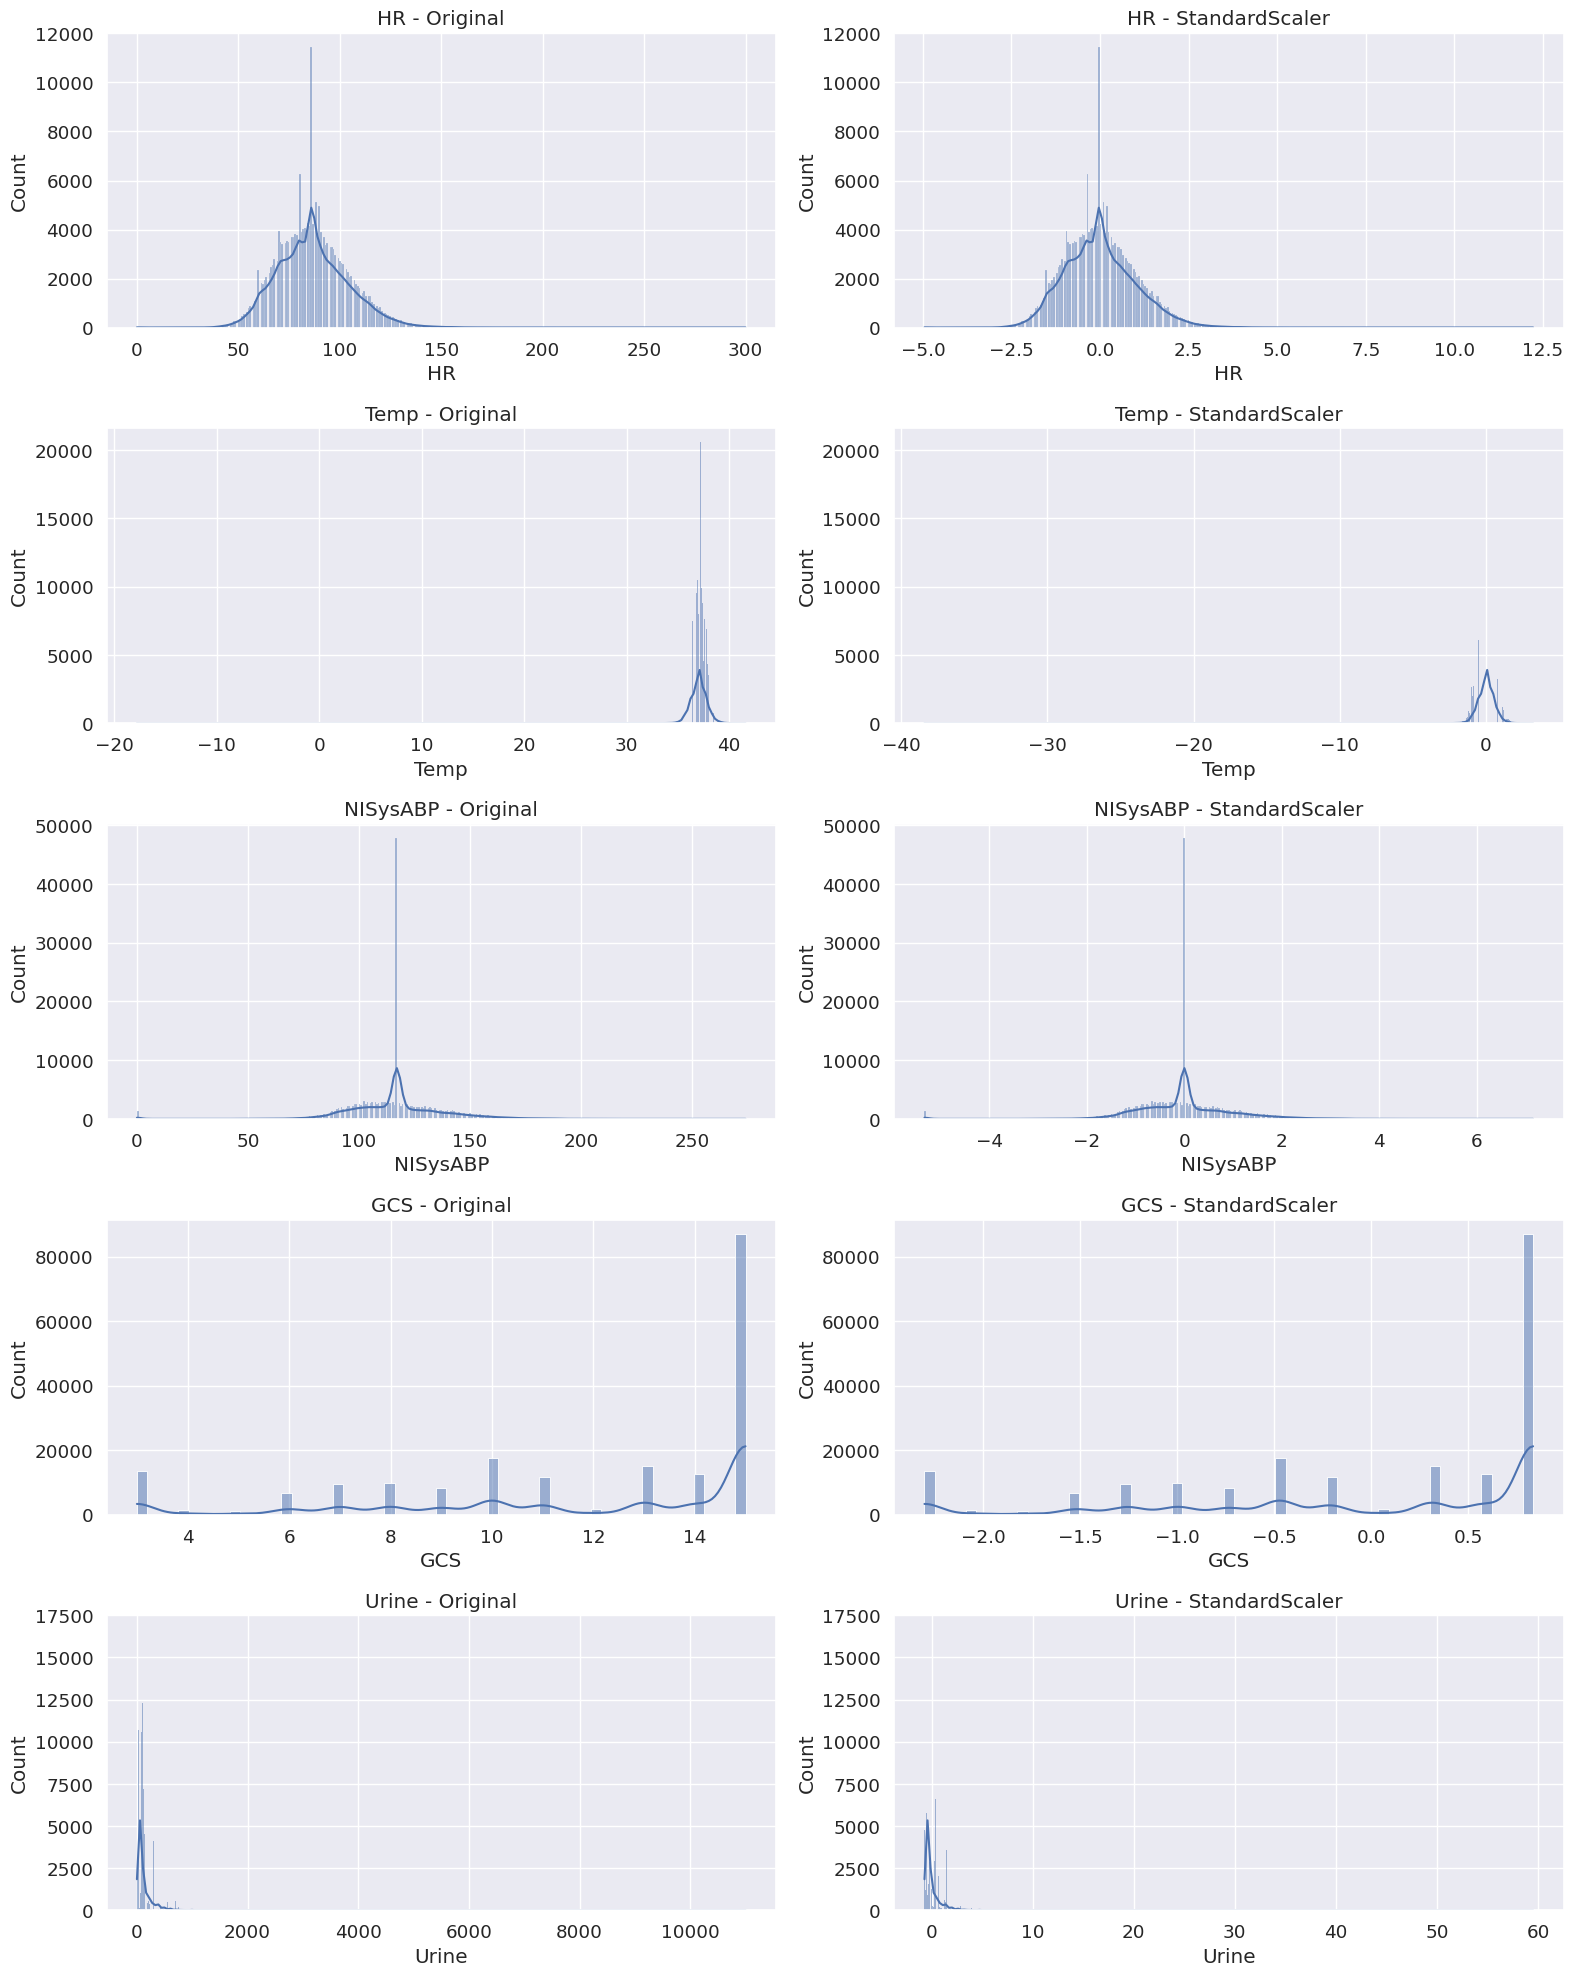

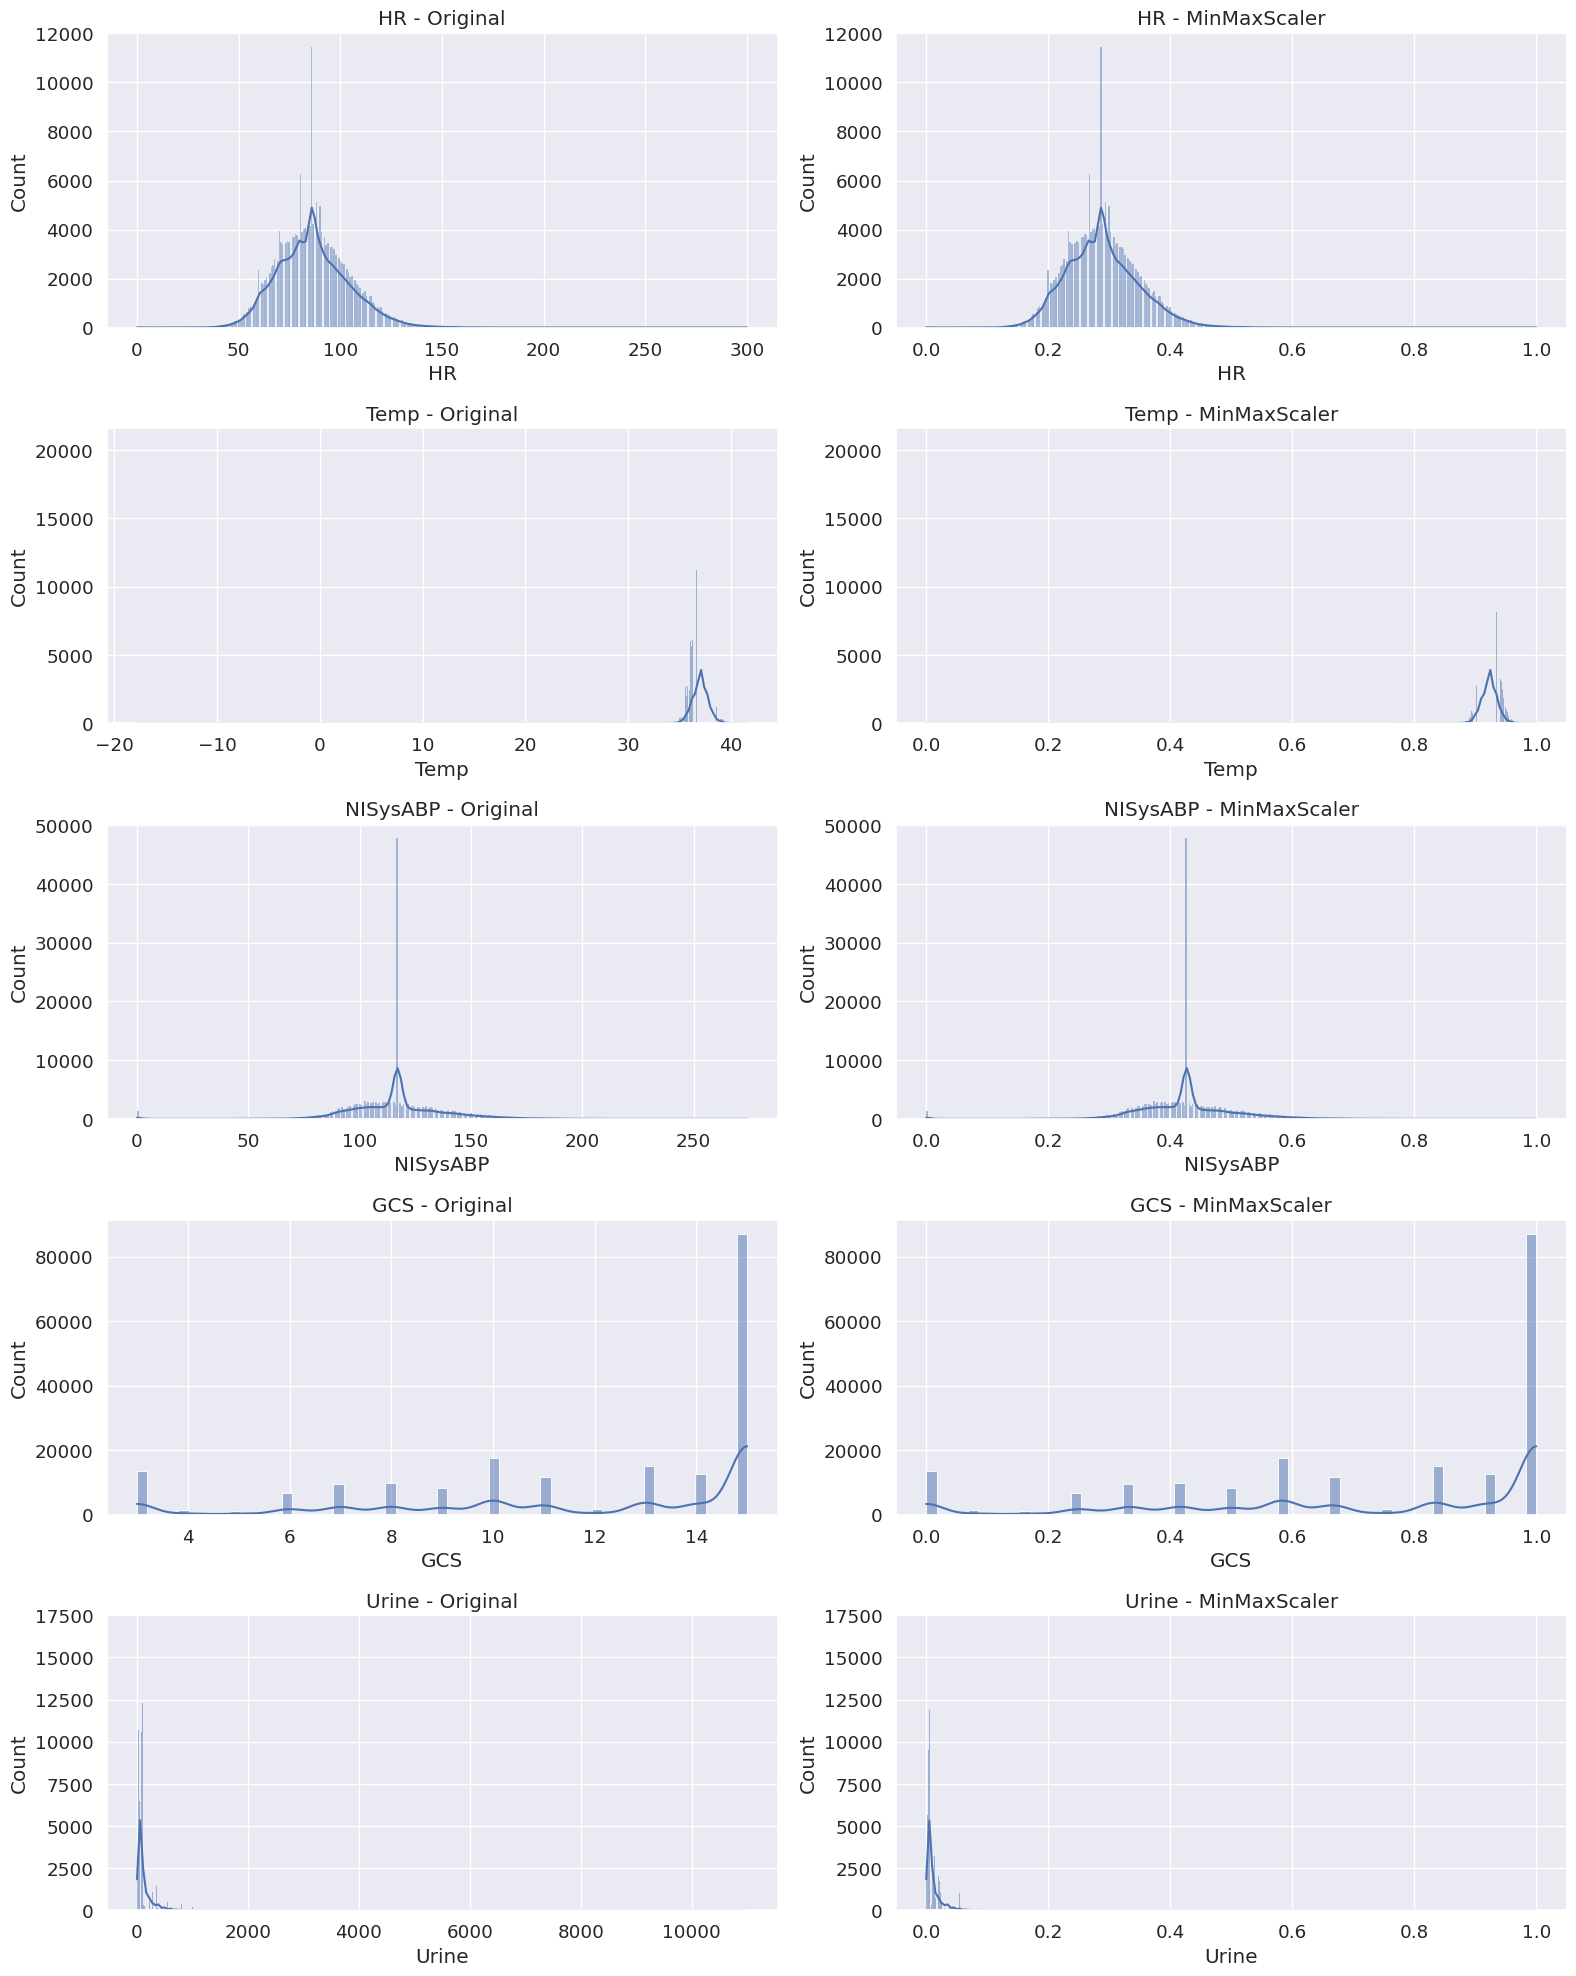

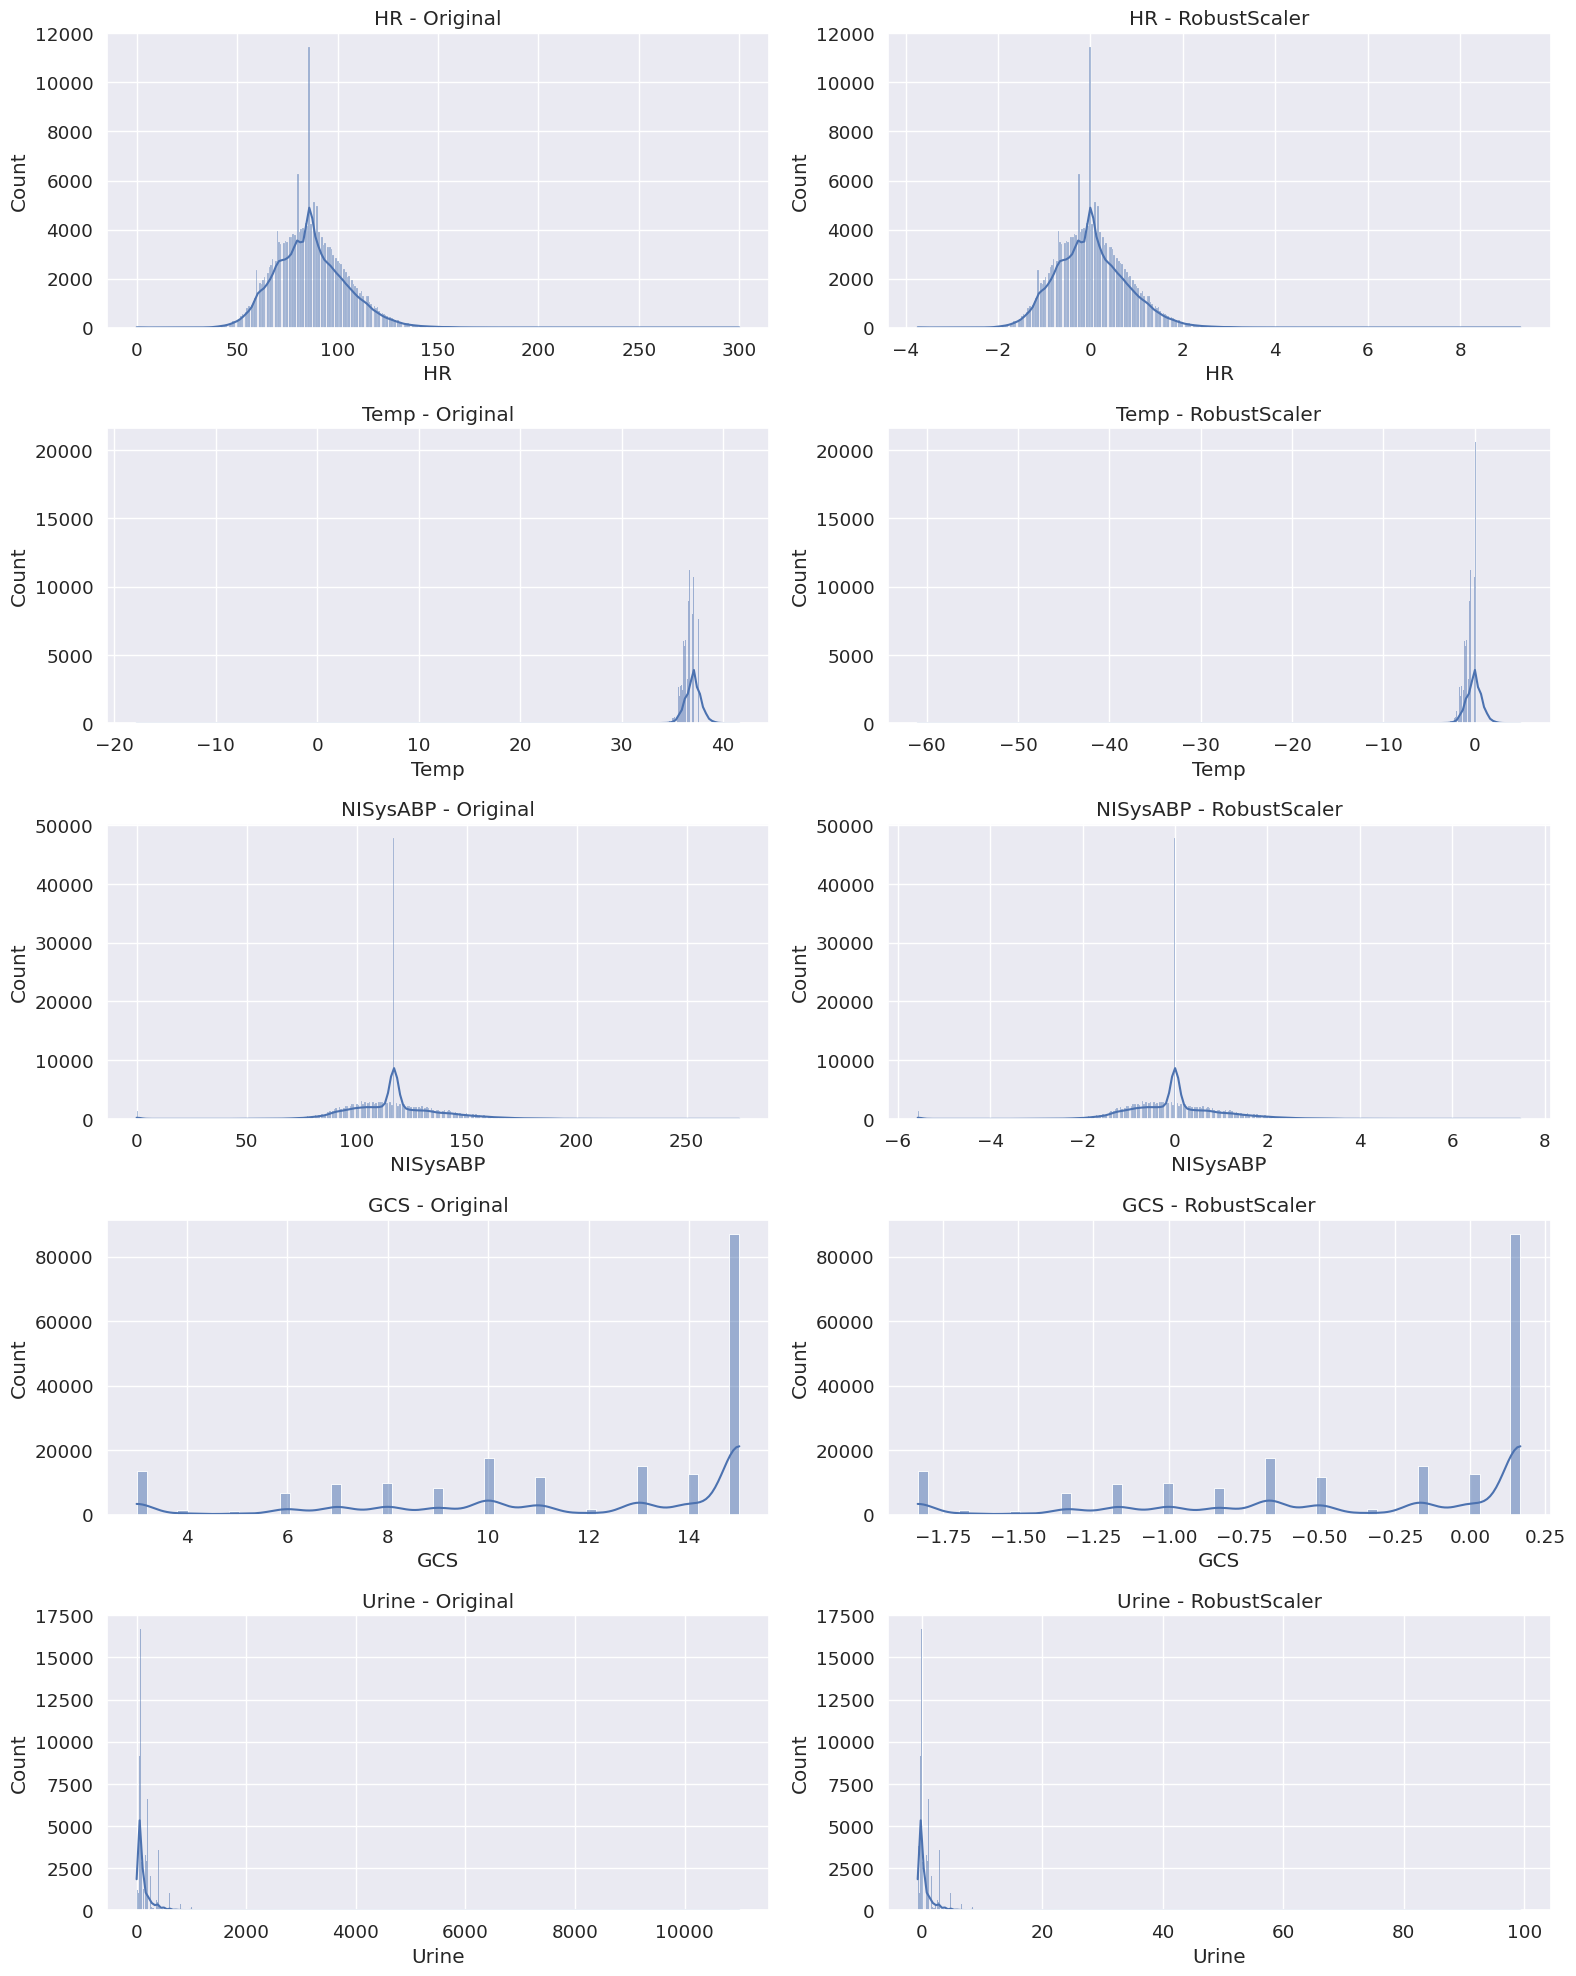


Selected scaling method: RobustScaler
Reason: Medical data often contains outliers, and RobustScaler is less sensitive to outliers.
RobustScaler uses quartiles for scaling, which makes it robust to extreme values.
Saved scaled data for set a
Saved scaled data for set b
Saved scaled data for set c

===== Additional Feature Engineering =====
Creating patient features for set a...
  Created 4000 patient records with 258 features
Creating patient features for set b...
  Created 4000 patient records with 258 features
Creating patient features for set c...
  Created 4000 patient records with 258 features

===== Preprocessing Summary =====
1. Missing Value Imputation:
   - Applied forward fill imputation to preserve temporal causality
   - Handled initial missing values with median imputation from the training set
   - Successfully eliminated all missing values

2. Data Scaling:
   - Selected RobustScaler for its robustness to outliers
   - All features scaled to be numerically stable for ML

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set(font_scale=1.2)
plt.rcParams["figure.figsize"] = (14, 8)

# Define paths
processed_path = 'processed_data'
ml_ready_path = 'ml_ready_data'
import os
os.makedirs(ml_ready_path, exist_ok=True)

# Load the processed data from Q1.1
print("Loading processed data...")
data_a = pd.read_parquet(f'{processed_path}/set-a.parquet')
data_b = pd.read_parquet(f'{processed_path}/set-b.parquet')
data_c = pd.read_parquet(f'{processed_path}/set-c.parquet')

# Define the sets
sets = {
    'a': data_a,
    'b': data_b,
    'c': data_c
}

# Identify variable types
static_vars = ['Age', 'Gender', 'Height', 'Weight']  # ICUType excluded as per instructions
id_vars = ['PatientID', 'RecordID', 'Hour']
target_var = 'In_hospital_death'

# Identify time series variables (excluding static, ID, and target variables)
time_series_vars = [col for col in data_a.columns 
                   if col not in static_vars + id_vars + ['ICUType', target_var]]

print(f"Static variables: {static_vars}")
print(f"Time series variables: {len(time_series_vars)}")
print(f"Target variable: {target_var}")

# === Part 1: Forward Fill Imputation ===
print("\n===== Forward Fill Imputation =====")

def forward_fill_patient_data(patient_data):
    """
    Apply forward fill imputation to a single patient's data.
    This preserves temporal causality by only using past values.
    """
    # Sort by hour to ensure chronological order
    patient_data = patient_data.sort_values('Hour')
    
    # Forward fill within the patient's data
    filled_data = patient_data.fillna(method='ffill')
    
    return filled_data

def handle_missing_initial_values(patient_data, col):
    """
    Handle cases where there's no previous value to forward fill
    by using different strategies depending on the variable type.
    """
    # If the column still has NaN values after forward fill, 
    # it means there was no initial value
    if patient_data[col].isna().any():
        # For static variables, we can use the patient's later values if available
        if col in static_vars:
            non_na_val = patient_data[col].dropna().values
            if len(non_na_val) > 0:
                # If any value exists, use it
                patient_data[col] = patient_data[col].fillna(non_na_val[0])
            else:
                # If no value exists at all, use the median from the train set
                patient_data[col] = patient_data[col].fillna(col_medians.get(col, 0))
        
        # For time series variables, use 0 for initial missing values
        # This is a simple baseline approach that can be improved later
        else:
            # Find the first hour with a non-NaN value
            first_valid_hour = patient_data.loc[patient_data[col].notna(), 'Hour'].min()
            
            if pd.isna(first_valid_hour):
                # If all values are NaN, use the median from training set
                patient_data[col] = patient_data[col].fillna(col_medians.get(col, 0))
            else:
                # For hours before the first valid measurement, use the median
                early_mask = patient_data['Hour'] < first_valid_hour
                patient_data.loc[early_mask, col] = patient_data.loc[early_mask, col].fillna(col_medians.get(col, 0))
    
    return patient_data

# Process each set
imputed_sets = {}
for set_id, data in sets.items():
    print(f"Processing set {set_id}...")
    
    # Calculate medians from this set for initial value imputation
    # We'll calculate medians for all variables from set 'a' only (our training set)
    if set_id == 'a':
        col_medians = {}
        for col in static_vars + time_series_vars:
            col_medians[col] = data[col].median()
    
    # Process each patient
    imputed_data_list = []
    for patient_id in data['PatientID'].unique():
        # Get the patient's data
        patient_data = data[data['PatientID'] == patient_id].copy()
        
        # Apply forward fill
        patient_data = forward_fill_patient_data(patient_data)
        
        # Handle initial missing values for each column
        for col in static_vars + time_series_vars:
            patient_data = handle_missing_initial_values(patient_data, col)
        
        imputed_data_list.append(patient_data)
    
    # Combine all patients back into one dataset
    imputed_data = pd.concat(imputed_data_list, ignore_index=True)
    
    # Store the imputed dataset
    imputed_sets[set_id] = imputed_data
    
    # Check for any remaining missing values
    missing_count = imputed_data[static_vars + time_series_vars].isna().sum().sum()
    print(f"  Remaining missing values in set {set_id}: {missing_count}")
    
    # If there are still missing values, fill them with global medians
    if missing_count > 0:
        for col in static_vars + time_series_vars:
            if imputed_data[col].isna().any():
                imputed_data[col] = imputed_data[col].fillna(col_medians.get(col, 0))
        
        missing_count = imputed_data[static_vars + time_series_vars].isna().sum().sum()
        print(f"  After final imputation, remaining missing values: {missing_count}")

# === Part 2: Data Scaling ===
print("\n===== Data Scaling =====")

# Based on the exploratory analysis, we need to choose an appropriate scaling method
# Let's examine the distributions of a few key variables

def plot_distribution_before_after_scaling(original_data, scaled_data, vars_to_plot, scaler_name):
    """Plot the distribution of variables before and after scaling."""
    n_vars = len(vars_to_plot)
    fig, axs = plt.subplots(n_vars, 2, figsize=(16, 4 * n_vars))
    
    for i, var in enumerate(vars_to_plot):
        # Before scaling
        sns.histplot(original_data[var].dropna(), kde=True, ax=axs[i, 0])
        axs[i, 0].set_title(f'{var} - Original')
        
        # After scaling
        sns.histplot(scaled_data[var].dropna(), kde=True, ax=axs[i, 1])
        axs[i, 1].set_title(f'{var} - {scaler_name}')
    
    plt.tight_layout()
    plt.show()

# Let's compare different scaling methods on a few variables
train_data = imputed_sets['a']

# Select a few representative variables for visualization
sample_vars = []
# Try to include variables from different categories if they exist in your dataset
for category in ['HR', 'Temp', 'SysABP', 'GCS', 'Urine']:
    matching_vars = [var for var in time_series_vars if category in var]
    if matching_vars:
        sample_vars.append(matching_vars[0])

if len(sample_vars) < 3:  # If we couldn't find enough of the specific ones
    # Add some additional vars to have at least 3
    additional_vars = [var for var in time_series_vars if var not in sample_vars][:3-len(sample_vars)]
    sample_vars.extend(additional_vars)

print(f"Sample variables for scaling comparison: {sample_vars}")

# Test different scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# We'll fit the scalers on the training data (set 'a')
fitted_scalers = {}
scaled_samples = {}

for scaler_name, scaler in scalers.items():
    # Fit on training data (excluding non-feature columns)
    fitted_scaler = scaler.fit(train_data[static_vars + time_series_vars])
    fitted_scalers[scaler_name] = fitted_scaler
    
    # Transform the sample for visualization
    scaled_data = train_data.copy()
    scaled_data[static_vars + time_series_vars] = fitted_scaler.transform(scaled_data[static_vars + time_series_vars])
    scaled_samples[scaler_name] = scaled_data
    
    # Plot original vs scaled distributions
    plot_distribution_before_after_scaling(train_data, scaled_data, sample_vars, scaler_name)

# Based on the visualization and properties of the data:
# - StandardScaler is good for normally distributed variables
# - MinMaxScaler maps to a fixed range (0-1) but is sensitive to outliers
# - RobustScaler is good for data with outliers

# For this application, we'll use RobustScaler as it handles outliers well
# and medical data often contains outliers
selected_scaler = 'RobustScaler'
print(f"\nSelected scaling method: {selected_scaler}")
print("Reason: Medical data often contains outliers, and RobustScaler is less sensitive to outliers.")
print("RobustScaler uses quartiles for scaling, which makes it robust to extreme values.")

# Apply the selected scaler to all sets
final_scaled_sets = {}
for set_id, imputed_data in imputed_sets.items():
    # Create a copy of the data
    scaled_data = imputed_data.copy()
    
    # Apply the scaler (which was fitted on the training set)
    scaled_data[static_vars + time_series_vars] = fitted_scalers[selected_scaler].transform(
        scaled_data[static_vars + time_series_vars])
    
    # Store the scaled dataset
    final_scaled_sets[set_id] = scaled_data
    
    # Save to parquet
    scaled_data.to_parquet(f'{ml_ready_path}/set-{set_id}-scaled.parquet')
    print(f"Saved scaled data for set {set_id}")

# === Part 3: Prepare for Machine Learning (Feature Engineering) ===
print("\n===== Additional Feature Engineering =====")

# Function to create patient-level features
def create_patient_features(data):
    """
    Create patient-level features from the time series data.
    This aggregates the 49 hourly measurements into summary statistics.
    """
    # Group by patient
    patient_features = []
    
    for patient_id in data['PatientID'].unique():
        # Get the patient's data
        patient_data = data[data['PatientID'] == patient_id].copy()
        
        # Sort by hour
        patient_data = patient_data.sort_values('Hour')
        
        # Initialize feature dict with patient ID and target
        features = {
            'PatientID': patient_id,
            target_var: patient_data[target_var].iloc[0]  # All rows have the same target value
        }
        
        # Add static features (use the first row since they're constant)
        for var in static_vars:
            features[var] = patient_data[var].iloc[0]
        
        # Add ICUType as a reference (not for training)
        if 'ICUType' in patient_data.columns:
            features['ICUType'] = patient_data['ICUType'].iloc[0]
        
        # For time series variables, calculate summary statistics
        for var in time_series_vars:
            # Skip if all values are NaN
            if patient_data[var].isna().all():
                continue
                
            # Basic statistics
            features[f'{var}_mean'] = patient_data[var].mean()
            features[f'{var}_std'] = patient_data[var].std()
            features[f'{var}_min'] = patient_data[var].min()
            features[f'{var}_max'] = patient_data[var].max()
            
            # Trend: difference between last and first measurement
            features[f'{var}_trend'] = patient_data[var].iloc[-1] - patient_data[var].iloc[0]
            
            # Rate of change: average hourly change
            if len(patient_data) > 1:
                changes = patient_data[var].diff().dropna()
                features[f'{var}_rate'] = changes.mean()
            
            # Variability: coefficient of variation
            if patient_data[var].mean() != 0:
                features[f'{var}_cv'] = patient_data[var].std() / abs(patient_data[var].mean())
        
        patient_features.append(features)
    
    # Convert to DataFrame
    patient_features_df = pd.DataFrame(patient_features)
    
    return patient_features_df

# Create patient-level features for each set
patient_features_sets = {}
for set_id, scaled_data in final_scaled_sets.items():
    print(f"Creating patient features for set {set_id}...")
    patient_features = create_patient_features(scaled_data)
    patient_features_sets[set_id] = patient_features
    
    # Save to parquet
    patient_features.to_parquet(f'{ml_ready_path}/patient_features-{set_id}.parquet')
    print(f"  Created {len(patient_features)} patient records with {len(patient_features.columns)} features")

# === Part 4: Summary and Next Steps ===
print("\n===== Preprocessing Summary =====")
print("1. Missing Value Imputation:")
print("   - Applied forward fill imputation to preserve temporal causality")
print("   - Handled initial missing values with median imputation from the training set")
print("   - Successfully eliminated all missing values")

print("\n2. Data Scaling:")
print(f"   - Selected {selected_scaler} for its robustness to outliers")
print("   - All features scaled to be numerically stable for ML algorithms")
print("   - Scaling parameters fitted only on the training set (set 'a')")

print("\n3. Feature Engineering:")
print("   - Created patient-level features from time series data")
print("   - Included static variables and summary statistics of time series variables")
print("   - Added trend and variability metrics to capture temporal patterns")

print("\nNext Steps:")
print("1. Train machine learning models using the processed data")
print("2. Evaluate model performance using the AuROC and AuPRC metrics")
print("3. Compare different model architectures and feature sets")